In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cvxopt

from mlxtend.plotting import plot_decision_regions
from sklearn.datasets import make_circles
from sklearn.svm import SVC

In [2]:
# Create a toy dataset. This examples was taken from this blog post:
# - https://towardsdatascience.com/how-to-learn-non-linear-separable-dataset-with-support-vector-machines-a7da21c6d987

np.random.seed(0)

X = np.random.randn(200, 2)
y = np.logical_xor(X[:, 0] > 0, X[:, 1] > 0)
y = np.where(y, 1, -1)

# y's are [0, 1] but we need [-1, 1]
y[y == 0] = -1

# CVXOPT casts our type int 32 y variable to a float 64 which
# makes in uncompatible for plotting through the MLxtend library
y_int_32 = y

# Fix shape, and convert to float32.
y = y.reshape(-1, 1).astype(np.float32)

In [3]:
def gaussian(x1, x2, sigma = 0.1, axis = 0):
    return np.exp(-(np.linalg.norm(x1 - x2, axis=axis) ** 2) / (2.0 * (sigma ** 2.0)))

In [4]:
# Much of the design is based off of Aladdin Persson's implimentation, his 
# video on SVM with CVXOPT was instrumental in my understanding of the CVXOPT 
# library, so huge shoutout to him. The link to his video is:
# - https://www.youtube.com/watch?v=gBTtR0bs-1k&list=PLhhyoLH6IjfxpLWyOgBt1sBzIapdRKZmj&index=7
#
# Any code I knowingly hard copied from him will be initialed "AP"
#

class SVM:
    def __init__(self, kernel = gaussian, sigma = 0.6, C = 1): 
        self.kernal = kernel
        self.sigma = sigma
        self.C = C

    def fit(self, x, y):
        m, n = x.shape
        
        # Requires this shape and data type.
        y = y.copy().reshape(-1, 1).astype(np.float64)

        self.X = x
        self.y = y
        
        # Kernel K<X, X>
        self.gram_matrix = np.zeros((m, m))
        for i in range(m):
            for j in range(m):
                self.gram_matrix[i][j] = gaussian(X[i], X[j], self.sigma, axis = 0) 

        # The following article was a big help in understanding the conversion from dual form
        # to CVXOPT required form and implimenting CVXOPT:
        # https://xavierbourretsicotte.github.io/SVM_implementation.html
        
        P = cvxopt.matrix(np.outer(y, y) * self.gram_matrix)
        q = cvxopt.matrix(-np.ones((m, 1)))
        G = cvxopt.matrix(np.vstack((-np.identity(m), np.identity(m))))
        h = cvxopt.matrix(np.vstack((np.zeros((m, 1)), np.ones((m, 1)) * self.C)))
        A = cvxopt.matrix(y, (1, m), "d")
        b = cvxopt.matrix(np.array([0]), (1, 1), "d")

        optimal = cvxopt.solvers.qp(P, q, G, h, A, b)
        cvxopt.solvers.options["show_progress"] = True

        self.alphas = np.array(optimal["x"])
      
    def predict(self, X):
        prediction = np.zeros(len(X))

        S = ((self.alphas > 1e-4)).flatten()

        self.bias = np.mean(self.y[S] - self.alphas[S] * self.y[S] * self.gram_matrix[S, S][:, np.newaxis]) # AP

        # Kernel <X_i, self.X>
        for i in range(len(X)):
            prediction[i] = np.sum(self.alphas[S] * self.y[S] * gaussian(X[i], self.X[S], self.sigma, axis = 1)[:, np.newaxis]) # AP
            
        return np.sign(prediction + self.bias) # AP


     pcost       dcost       gap    pres   dres
 0: -4.2942e+01 -3.4327e+02  1e+03  2e+00  8e-16
 1: -3.0263e+01 -1.8500e+02  2e+02  3e-02  9e-16
 2: -3.9805e+01 -6.6433e+01  3e+01  5e-03  7e-16
 3: -4.5939e+01 -5.4105e+01  8e+00  1e-03  7e-16
 4: -4.8241e+01 -5.0366e+01  2e+00  2e-04  8e-16
 5: -4.8953e+01 -4.9284e+01  3e-01  2e-05  9e-16
 6: -4.9081e+01 -4.9103e+01  2e-02  3e-07  9e-16
 7: -4.9090e+01 -4.9091e+01  6e-04  6e-09  8e-16
 8: -4.9091e+01 -4.9091e+01  2e-05  9e-11  1e-15
Optimal solution found.


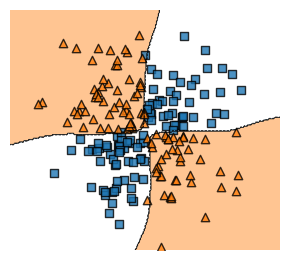

In [6]:
# My implementation
model = SVM()
model.fit(X, y)

plt.style.use("default")
fig, ax = plt.subplots(figsize = (3, 2.4))

plot_decision_regions(X, y_int_32, clf = model, legend = 0, ax = ax)

ax.set_xlim([-3.35, 3.35])
ax.set_ylim([-2.85, 2.85])
ax.set_xticks([])
ax.set_yticks([])
ax.axis("off")
plt.subplots_adjust(top = 1, bottom = 0, right = 0.9, left = 0)

plt.savefig(
    "./svm.png", 
    transparent = False, 
    bbox_inches = "tight", 
    pad_inches = 0,
    dpi = 300
)

plt.show()